# Data Analytics Course 2018

## Introduction.
In this notebook we're going to use **supervise learning techniques** to understand and classify domains as being 'legit' or having a high probability of being generated by a DGA (Domain Generation Algorithm). 

The **learning objective** of this assignment focus on the use of ```sci-kit learn``` library for machine learning, as well as build upon the techniques of ```pandas``` and ```matplotlib``` learned from last assignment. The exercise intentionally shows common missteps, warts in the data, paths that didn't work out that well and results that could definitely be improved upon. In general capturing what worked and what didn't is not only more realistic but often much more informative.

### The Problem Scenario

Domain generation algorithms, or DGAs, are commonly used by malware to generate a wide variety of domains to bypass whitelists for C2 callbacks. The domains generated are usually in the form of www.\<gibberish\>.com (e.g axwscwsslmiagfah.com). 

<img src="./images/LSTMblack background.jpeg" alt="drawing" width="400px"/>

While there exists no deterministic way short of knowing the algorithm itself to identify a DGA generated domain, we can roughly tell by the amount of gibberish that is in the domain. This observation will be the basis of the DGA detection model that we will build in this assignment.

### Python Modules Used:
- Pandas: Python Data Analysis Library (http://pandas.pydata.org)
- Scikit Learn (http://scikit-learn.org) Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Matplotlib:  Python 2D plotting library (http://matplotlib.org)


In [1]:
# Setup
import sklearn.feature_extraction
import pandas as pd
import pylab

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set default pylab parameters to figure
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

## Creating the Labeled Dataset

Supervised learning models must be built from labeled dataset. Think of it as training a toddler to read a picture book. The toddler (the model) is trying to map the pictures (input) to words/labels (output) beside the pictures or the sounds emitted by an adult (if the adult is reading to him/her).


<img src="./images/toddler-supervised-learning.jpg" alt="drawing" width="200px"/>

This is supervised learning seen in daily life. To do that, somebody has to create the picture book (labeled dataset) or the parent had to have gone through their own childhood education to know the labels. Therefore, for this first part, we shall focus on building the labeled dataset for this DGA toddler.

### Load Legitimate Domain Set with Pandas Dataframe.
The first step is to load the data from file into a pandas dataframe, much like in assignment 1.

The code below loads a csv file **'alexa_100k.csv'** into a dataframe called ```alexa_dataframe```. In the same line, we also set the _```header=None```_ since the csv file has no header. We specify the column names to be ```rank``` and ```uri```.

Typing **alexa_dataframe.head()** prints the first 5 entries of the dataframe. _Try it by pressing **SHIFT+ENTER** on the cell_!

This dataframe will contain all legitimate domains.

In [2]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')

In [3]:
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


### Extract Second Level Domain with TLDExtract
For this exercise, we are only interested in the **2nd level domain**. For example, we are only interested in 'facebook' in 'www.facebook.com' for analysis.

Here is a nice little function that we have written for you to extract the domain using an library called _tldextract_. You will just need to call it in the following exercise.

In [4]:
# Okay for this exercise we need the 2nd level domain and nothing else
# We will use TLDextract module to extract this.
import tldextract
import numpy as np

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

### Problem 1: Data Processing in Dataframe
Now let's do some data manipulation! Since we are only interested in the 2nd level domain, we are going to use the **domain_extract()** function to parse the 'uri' column of **alexa_dataframe**.

#### What you need to do specifically:
1. Use ```domain_extract()``` to extract all 2nd level domains from ```uri``` column into a new ```domain``` column.
2. Delete the ```rank``` and ```uri``` column after extracting the domain.
3. Clean the data by removing ```NaN``` and duplicate entries.
4. Label this set of data 'legit'.

#### More hints:
One of the reason why Pandas dataframe is a convenient data structure for data manipulation because you can extract an entire column if you know the column name:
```python
# To extract column 'col' from my_dataframe.
my_dataframe['col']
```
We can also delete an entire column
```python
# Deleting 'col' from my_dataframe.
del my_dataframe['col']
```

In [5]:
alexa_dataframe['uri'].values

array(['facebook.com', 'google.com', 'youtube.com', ..., 'sat1.ch',
       'nahimunkar.com', 'musi.pk'], dtype=object)

In [6]:
"""
Problem 1a:
Write the code to do the following:
1. Extract the 'uri' column from the alexa_dataframe
2. For each uri in the column, pass to domain_extract() function to get the 2nd level domain.
3. Put the extracted 2nd level domains into a new column 'domain'.
4. Delete the 'rank' and 'uri' column from alexa_dataframe as we no longer need them.
"""
alexa_dataframe['domain'] = alexa_dataframe['uri'].apply(domain_extract)
del alexa_dataframe['rank'], alexa_dataframe['uri'] 

In [7]:
print('Size of alexa_dataframe before cleaning: %d' %alexa_dataframe.shape[0])

Size of alexa_dataframe before cleaning: 100000


In [8]:
"""
Problem 1b:
Data cleaning! Use pandas dataframe API to drop all NaN entries and duplicate entries.
"""
alexa_dataframe.dropna(inplace=True)
alexa_dataframe.drop_duplicates(inplace=True)

In [9]:
print('Size of alexa_dataframe after cleaning: %d' %alexa_dataframe.shape[0])

Size of alexa_dataframe after cleaning: 91377


In [10]:
"""
Problem 1c:
Add a new column to alexa_dataframe and name it 'class'. Label all entries as 'legit'
"""
alexa_dataframe['class'] = 'legit'

In [11]:
alexa_dataframe.head()

,domain,class
0,facebook,legit
1,google,legit
2,youtube,legit
3,yahoo,legit
4,baidu,legit


### Exercise 2: Data Slicing
In machine learning, it is often important to split the data (<a href='#cross-validation'>Why do we need to split data?</a>). In this exercise, you are going to try to split the dataframe into 90% training and 10% hold out. Rename the hold out dataframe as **hold_out_alexa** and the 90% set as **alexa_dataframe**.

#### Hint: Dataframe Indexing
We have seen earlier how to select a column of dataframe. In the other dimension, we can also select the rows in a dataframe by giving it a numerical:
```python
# Selecting 3rd row of my_dataframe
my_dataframe[2]
```

We can also grab a range:
```python
# Selecting a range from row 2 - 10
my_dataframe[1:10]
# Or up to 10
my_dataframe[:10]
# Or from 10 onwards
my_dataframe[10:]
```

In [12]:
# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]

"""
Problem 1d:
Create a holdout set of 10% of the total alexa domains
"""
split = int(0.1 * alexa_total)
hold_out_alexa, alexa_dataframe = alexa_dataframe[:split], alexa_dataframe[split:]

In [13]:
print('Total Alexa domains %d' % alexa_total)
print('Number of Alexa domains: %d' % alexa_dataframe.shape[0])

Total Alexa domains 91377
Number of Alexa domains: 82240


In [14]:
alexa_dataframe.head()

,domain,class
64844,gurtam,legit
2070,donga,legit
50400,aattp,legit
5306,intporn,legit
70660,atbatt,legit


### Summary: Data Preparation
What you have just tried is a flavor of doing **data preparation** using Pandas Dataframe. That was just the legitimate domains. The code below prepares a dataframe of actual DGA domains and finally concatenates them together into a complete data set for training.

Of course keep in mind that we are very pampered here since DGA Domains and Alexa Domains were packaged nicely in '.csv' and '.txt' files for us. The real world is more cruel. Don't be surprised that **majority of the work** is done on extracting these data from different data sources, cleaning out corrupted entries and consolidating them into convenient schema.

We will do the same for DGA domains below.

In [15]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# We noticed that the blacklist values just differ by captilization or .com/.org/.info
# <Try map operation>
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# It's possible we have NaNs from blanklines or whatever
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Total DGA domains %d' % dga_total)

# Set the class
dga_dataframe['class'] = 'dga'

# Hold out 10%
hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print('Number of DGA domains: %d' % dga_dataframe.shape[0])

Total DGA domains 2664
Number of DGA domains: 2397


In [16]:
dga_dataframe.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [17]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
#all_domains

## Part 2: Feature Engineering
After the data has been extracted, a data scientist must design features that can hopefully help us tell DGA Domains apart from legitimate domains. The first 2 features that we are going to experiment with is simply the **length** and the **entropy** of the domain.

#### Food for Thought:
>What are some of the features you can come up with?

The code in the next cell extracts the length of the domain to be used as one of the features.

In [18]:
# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Since we're trying to detect dynamically generated domains, short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

### Exercise 3: Write your own entropy function
So we have made our first feature, which is the length of domains, but this is not good enough. In machine learning problems, the more **meaningful** features you can derive the better the results.

To make our second feature, we introduce the concept of **entropy**. **Entropy** is a measure of the amount of disorder in a system. For example, if I have two strings '35-sdf-09jq43r' and 'facebook', the former will have higher entropy as it is more disorderly.

#### What you need to do specifically:
In this exercise, you will have to write your own entropy function for use in feature extraction. The equation for calculating entropy is 

$$ H(S) = - \sum_{i=1}^n P(s_i)\log_b P(s_i) $$

Where $S$ is the set of all letters in a string and $P(s_i)$ is the probability of finding letter, $s_i$, in your input string. 

Specifically, you will have to calculate the number of occurrances of a letter in a string and divide by the length of the string to get $P(s_i)$ for one letter. Do this for all letters and sum them up according to the formula. 

#### Hints:
1. There is a log function in python's **math** library (already imported for you) to calculate logarithms. Just call it with the right parameters.
2. Use the **Counter()** function (already imported for you) to calculate the occurance of each letter.
3. Remember to convert your length of string to float before division.
4. Raise your hands if you need help.

[Jason] Why do you need to convert to float? Python seem to does it automatically already

In [19]:
# Grabbed this from Rosetta Code (rosettacode.org)
import math
from collections import Counter

s = 'facebook'
def entropy(s):
    """
    Problem 3a:
    Code out the math function above to calculate entropy. Return the calculated entropy.
    :param: s - input string
    :return: calculated entropy
    """
    return -sum([i/len(s) * math.log(i/len(s), 2) for i in Counter(s).values()])

Test your entropy function here.

**Expected output:** 2.75

In [20]:
entropy('facebook')

2.75

In [21]:
# Add a entropy field for the domain
all_domains['entropy'] = all_domains['domain'].apply(entropy)

In [22]:
all_domains.head()

,domain,class,length,entropy
3,intporn,legit,7,2.521641
5,submitterbot,legit,12,3.022055
7,clubedosvideos,legit,14,3.235926
8,matchlatam,legit,10,2.446439
9,dressuplive,legit,11,3.095795


In [23]:
all_domains.tail()

,domain,class,length,entropy
84632,ulxxqduryvv,dga,11,2.913977
84633,ummvzhin,dga,8,2.750000
84634,umsgnwgc,dga,8,2.750000
84635,umzsbhpkrgo,dga,11,3.459432
84636,umzuyjrfwyf,dga,11,2.913977


### Lets plot some stuff!

This is great! We now have two features: **length** and **entropy**. Are these really great features? We don't really know at this point. This is where plotting the data can be very useful.

As we have two features, our data now virtually lives on a two dimensional universe that we have created (This is an abstract concept which you will understand once you plot the data). The question we want to ask is: **In this 2D universe, can we draw a line to separate the data?**.

We will use a python plotting library (pylab) to find out.

In [24]:
from matplotlib import pyplot as plt

In [25]:
all_domains.head()

,domain,class,length,entropy
3,intporn,legit,7,2.521641
5,submitterbot,legit,12,3.022055
7,clubedosvideos,legit,14,3.235926
8,matchlatam,legit,10,2.446439
9,dressuplive,legit,11,3.095795


In [26]:
def plot2Dfeatures(df, dim1, dim2, condition):
    """
    Problem 3b:
    Write the plot function to generate a scatterplot of DGA and legit domains
    """
    # Write your code here.
    dga_df = df[condition]
    legit_df = df[~condition]
    plt.scatter(legit_df[dim1].values, legit_df[dim2].values, c='cyan', alpha=0.2, s=140, label='Legit')
    plt.scatter(dga_df[dim1].values, dga_df[dim2].values, c='black', alpha=0.3, s=80, label='DGA')
    plt.xlabel('domain ' + dim1)
    plt.ylabel('domain ' + dim2)
    plt.legend(loc=1)
    plt.show()

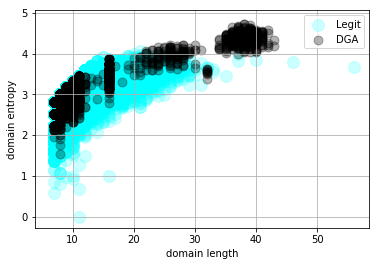

In [27]:
condition = all_domains['class'] == 'dga'
plot2Dfeatures(all_domains, 'length', 'entropy', condition)

Above you can see that our DGA domains do tend to have higher entropy than Alexa on average. Based on this plot, we can already tell if entropy and length are enough to build a model to separate DGA from legit domains. 

Can you tell if these two features are enough? Why?

In [28]:
# Lets look at the types of domains that have entropy higher than 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print ('Num Domains above 4 entropy: %.2f%% %d (out of %d)' % (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0]))
print ("Num high entropy legit: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0])
print ("Num high entropy DGA: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0])
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

Num Domains above 4 entropy: 0.57% 361 (out of 62987)
Num high entropy legit: 3
Num high entropy DGA: 358


,domain,class,length,entropy
7580,theukwebdesigncompany,legit,21,4.070656
43414,congresomundialjjrperu2009,legit,26,4.056021
77781,burzhunetdlyachaynikov,legit,22,4.004886


In [29]:
high_entropy_domains[high_entropy_domains['class']=='dga'].head()

,domain,class,length,entropy
82258,a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52,dga,37,4.540402
82259,a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq,dga,39,4.631305
82260,a17d60gtnxk47gskti15izhvlviyksh64nqkz,dga,37,4.270132
82261,a17erpzfzh64c69csi35bqgvp52drita67jzmy,dga,38,4.629249
82262,a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr,dga,41,4.305859


Looking at the results above, we do see that there are more domains in the DGA group that are high entropy but only a small percentage of the legit domains are in that high entropy range...

## Part 3: Machine Learning

Once we are satisfied with the features, we can throw the dataframe into a machine learning algorithm to train a model that will separate for us DGA from legitimate domains. In python, there is an awesome library called ```scikit-learn``` (imported as ```sklearn```) that has a suite of machine learning algorithms implemented for you.

For this lab, we will be using a **Random Forest**.

### To Build a Forest, One has to Plant a Tree

Out of the many machine learning methods available, **decision trees** can be considered one of the most popular and easiest to understand. In **decision tree learning**, a tree is "_grown_" by using the features of our data set as **splitting criteria**. In the example below, a pre-built decision tree is used to predict survival of passengers on the titanic. **Sex, age and number of siblings** are used as **splitting criteria**.

![](images/CART_tree.png)

From the decision tree, it is clear that if you are a male, aged 10 and above and has more than 2 siblings, you are likely to be a goner.

The specifics of how to build a decision tree from features given is complicated, but the high-level concept is similar to a toddler and a picture book. We first initialize a decision tree model, then throw it lots of labeled data as examples of titanic survivors, along with information such as sex, age and number of siblings, from which it will tune its parameters accordingly to form the final decision tree model that has learned how to predict if someone will survive the titanic.

We will apply this concept to DGA and legit domains.

### Random Forest

While **decision trees** may be simple, they can be prone to **overfitting**. A tree that is built on all features of the data set is likely to be very deep, and seldom generalize to unseen data set. To solve this problem, random subsets of features can be taken to build multiple trees. The predictions of these trees are then averaged across "_forest_" to give the final prediction results.

Luckily for us, **Scikit-Learn** library has both the **DecisionTreeClassifier** and the **RandomForestClassifier** implemented for us. All we need to do is to punch in the parameters in our code. In this lab, we build a **RandomForestClassifier** of 20 trees.

### Exercise 4: Build a RandomForestClassifier

In this exercise, you will make use of the scikit-learn library to make a random forest classifer. The general programming pattern of scikit-learn is as follows:

Instantiate a model

Example:

```python
from sklearn import ExampleClassifier
my_model = ExampleClassifier(hyperparameters)
```

Train your model with your data. Since scikit-learn classifiers only accept numpy arrays most of the time, we have to convert from pandas to numpy.

Example:
```python
my_model.fit(X_train, y_train)
```

After the model is trained, apply the model on new data to generate labels on new data.

Example:
```python
y_new = my_model.predict(X_new)
```

If we want to test accuracy of prediction on a data set that is already labeled, we can also throw in directly for scoring.

Example:
```python
score = my_model.score(X_test, y_test)
```

In [30]:
"""
Problem 4a:
Initialize a Random Forest model and assign it to the variable 'clf'.
"""
# YOUR CODE HERE
import sklearn.ensemble

model = sklearn.ensemble.RandomForestClassifier(n_estimators=20)

In [31]:
# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
X = all_domains[['length', 'entropy']].values

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings

In [32]:
"""
Problem 4b:
Train the Random Forest model 'clf' with the first 6000 X (feature vectors) and y (labels).
Use the trained model to predict the remaining data points and score the accuracy of the prediction.
"""
# YOUR CODE HERE

model.fit(X[:6000],y[:6000])
model.score(X[6000:],y[6000:])

0.9579377752820819

Expected Output: 0.9579635929991933

### Cross Validation
Sometimes, we do not have a specified test or training set. All we have is one set of labeled data to play with such as the case of this assignment. When this happens, it is good practice to perform cross-validation to determine if your strategy is working.

** As Scikit-Learn Documentation puts it:**
> Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**.

A common practice is to split your data set into three sets: ** Training Set, Validation Set, Test Set**. They are defined as follows:
1. **Training set:** A set of examples used for learning, that is to fit the parameters [e.g splitting criteria] of the classifier.
2. **Validation set:** A set of examples used to tune the hyperparameters [e.g number of trees in random forest] of a classifier.
3. **Test set:** A set of examples used only to assess the performance [generalization] of a fully specified classifier.

We have no validation set in this case so we will just use scikit learn's cross validation to assess predictive performance.

You may read more on cross-validation [here](https://www.openml.org/a/estimation-procedures/1).

In [33]:
"""
Problem 4c:
Perform 5-fold cross validation scoring on clf model using labeled dataset
"""
# YOUR CODE HERE
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, n_jobs=4)

In [34]:
print(scores)

[0.96816955 0.96848706 0.96991347 0.96864333 0.96411844]


Expected output ```[0.96748096 0.96652653 0.96771379 0.9671585  0.96287188]```

Wow 96% accurate! 

At this point we could claim success and we'd be gigantic morons. Recall that we have ~100k 'legit' domains and only 3.5k DGA domains. So a classifier that marked everything as legit would be about 96% accurate....

## Part 4: Examining Results
 
We dive in a bit and look at the predictive performance more deeply.

### Confusion Matrix
Because of the problem demonstrated above, nobody uses accuracy measure as the sole unit of performance measure in data analytics. In many cases, data scientists calculate four metrics: **False Positives, True Positives, False negatives and True Negatives**.

- **True positive** occurs when a positive sample is actually labelled as positive (A correct prediction of dga on a dga domain).

- **Fales positive** occurs when our model "cries wolf", meaning that a sample is labelled positive when it is actually a false alarm (A prediction of dga on a legit domain). In the context of cybersecurity (as seen in our dga data set), this can be very high because our data is skewed in the first place.

- **True negative** occurs when a negative sample is labelled as negative (A correct prediction of legit on legit domains).

- **False negative** occurs when the model predicts negative on a positive sample (A prediction of legit on dga domains).

<img src="./images/ConfusionMatrix.png" alt="drawing" width="400px"/>


In [35]:
# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.91% (12098/12109)
legit/dga: 0.09% (11/12109)
dga/legit: 82.00% (401/489)
dga/dga: 18.00% (88/489)


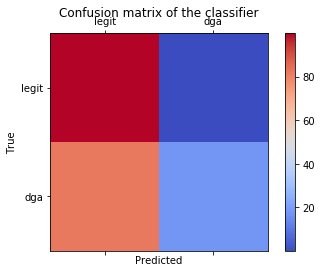

In [36]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T) 
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('True')
    pylab.show()

plot_cm(cm, labels)

### Failure:
We can see below that our suspicions were correct and the classifier is marking almost everything as legit. Actual DGA detection is at 18% and false positive rates are at 82%. We **FAIL**.. science is hard...

## Part 5: Redesigning the Features

When we fail at supervised learning, there may be a high chance that we are using the wrong features. 

Somebody with background in Natural Language Processing (NLP) tells us that NGrams is an important feature in language modeling, so we're going to compute NGrams for every Alexa main and see if we can use the NGrams to help us better differentiate and mark DGA domains.

For example, if our text is just "google", a **bi-gram** will give us **go,oo,og,gl,le**, each occuring once. 

### Exercise 5: Generating NGrams

Scikit learn has a nice NGram generator that can generate either **char** NGrams or **word** NGrams (we're using char). In this exercise, we will be using the ```CountVectorizer``` class of the ```sklearn.feature_extraction``` module.

**Parameters:** 
1. ```ngram_range=(3,5)```:  Give me all ngrams of length 3, 4, and 5
2. ```min_df=1e-4```: Minimumum document frequency. At 1e-4 we're saying give us NGrams that happen in at least .1% of the domains (so for 100k... at least 100 domains)

We are going to create **two features**:
1. **alexa_grams**: The number of matches between ngrams from input domains and ngrams from all legit domains in our dataset.
2. **word_grams**: The number of matches between ngrams from input domains and ngrams from an imported dictionary of words.

**Hint:**

Our strategy/algorithm for generating this features will be as follows:

1. Initialize a CountVectorizer with the right parameters.
2. Using the CountVectorizer, learn the vocabulary of ngrams and return a term-document matrix.
3. Count the total number of occurance of each ngrams and do a logarithm (to prevent frequent ngrams from blowing up in numbers)

Lastly, multiply this resulting count with the document-matrix of the entire dataset to measure the amount of match between the alexa domains/dictionary words and the domains in the dataset.

In [38]:
alexa_dataframe.head()

,domain,class
64844,gurtam,legit
2070,donga,legit
50400,aattp,legit
5306,intporn,legit
70660,atbatt,legit


In [122]:
from sklearn.feature_extraction.text import CountVectorizer

def ngram_extract(series, analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0):
    """
    Problem 5:
    Build the ngram feature extractor.
    :param: series - input pandas series of domain for building the ngram vocabulary
    :return: ngram_list - list of ngrams in vocabulary
    :return: counts - frequency count of ngrams
    :return: cv - count vectorizer
    """
    # YOUR CODE HERE
    cv = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    # The output is a SciPy sparse matrix instead of a NumPy array. A sparse matrix only stores the location of non-zero elements are is thus memory efficient.
    counts_matrix = cv.fit_transform(series)
    # getA1 will flatten the numpy array
    ngram_score = np.log10(counts_matrix.sum(axis=0).getA1())
    ngrams_list = cv.get_feature_names()
    return (ngrams_list, ngram_score, cv)

In [123]:
import operator

def sort_and_show(ngram_list, counts, label='Alexa'):
    _sorted_ngrams = sorted(zip(ngrams_list, counts), key=operator.itemgetter(1), reverse=True)
    print('{} NGrams: {}'.format(label, len(_sorted_ngrams)))
    for ngram, count in _sorted_ngrams[:10]:
        print(ngram, count)

In [124]:
# Sanity check
ngrams_list, alexa_counts, alexa_cv = ngram_extract(alexa_dataframe['domain'])
sort_and_show(ngrams_list, alexa_counts)

Alexa NGrams: 23876
ing 3.3948017771627113
lin 3.3809344633307017
ine 3.356599435724971
ter 3.218535505216528
tor 3.2166935991697545
ion 3.196728722623287
ent 3.185825359612962
por 3.1565491513317814
the 3.1501421618485588
tra 3.1156105116742996


In [125]:
all_domains['alexa_grams']= alexa_counts * alexa_cv.transform(all_domains['domain']).T 
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
0,elandroidelibre,legit,15,3.056565,61.803453,76.490247,-14.686794
2,judysbook,legit,9,2.947703,18.487734,15.157863,3.329871
3,1happybirthday,legit,14,3.235926,34.315496,27.482494,6.833003
4,spice-up-your-life,legit,18,3.461320,43.016057,27.443397,15.572661
7,easymodels,legit,10,2.921928,28.187306,26.967758,1.219547


In [126]:
# We're also going to throw in a bunch of dictionary words
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head()

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa


In [127]:
# Sanity check
ngrams_list, dict_counts, word_cv = ngram_extract(word_dataframe['word'])
sort_and_show(ngrams_list, dict_counts, label='Word')

Word NGrams: 25894
ing 4.387300822448285
ess 4.204879333760662
ati 4.1933472563864616
ion 4.165036479994566
ter 4.162415036106447
nes 4.112504458767161
tio 4.076822423342773
ate 4.0723602039634885
ent 4.069631102620343
tion 4.0496056125949735


In [128]:
# Compute NGram matches for all the domains and add to our dataframe
all_domains['alexa_grams']= alexa_counts * alexa_cv.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * word_cv.transform(all_domains['domain']).T
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
0,elandroidelibre,legit,15,3.056565,61.803453,76.490247,-14.686794
2,judysbook,legit,9,2.947703,18.487734,15.157863,3.329871
3,1happybirthday,legit,14,3.235926,34.315496,27.482494,6.833003
4,spice-up-your-life,legit,18,3.461320,43.016057,27.443397,15.572661
7,easymodels,legit,10,2.921928,28.187306,26.967758,1.219547


In [129]:
# Use the vectorized operations of the dataframe to investigate differences
# between the alexa and word grams
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
#all_domains.sort(['diff'], ascending=True).head(10) #depreciated
all_domains.sort_values(by='diff', ascending=True).head()
# The table below shows those domain names that are more 'dictionary' and less 'web'

,domain,class,length,entropy,alexa_grams,word_grams,diff
42754,stirringtroubleinternationally,legit,30,3.481728,131.344029,198.390123,-67.046093
46932,americansforresponsiblesolutions,legit,32,3.667838,143.780971,206.097885,-62.316914
29906,channel4embarrassingillnesses,legit,29,3.440070,96.735663,157.186225,-60.450562
33695,bipolardisorderdepressionanxiety,legit,32,3.616729,113.412427,171.437677,-58.025250
51636,pragmatismopolitico,legit,19,3.326360,59.751474,116.691559,-56.940086


In [130]:
#all_domains.sort(['diff'], ascending=False).head(50) # depreciated
all_domains.sort_values(by='diff', ascending=False).head()
# The table below shows those domain names that are more 'web' and less 'dictionary'

,domain,class,length,entropy,alexa_grams,word_grams,diff
34929,gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...,legit,56,3.661056,160.830027,79.853217,80.976810
43104,freegamesforyourwebsite,legit,23,3.551191,111.973465,59.335555,52.637909
72759,social-bookmarking-sites-list,legit,29,3.702472,143.968913,91.455297,52.513616
53258,stream-free-movies-online,legit,25,3.509275,118.717990,70.086307,48.631683
11088,best-online-shopping-site,legit,25,3.452879,122.007592,75.836217,46.171375


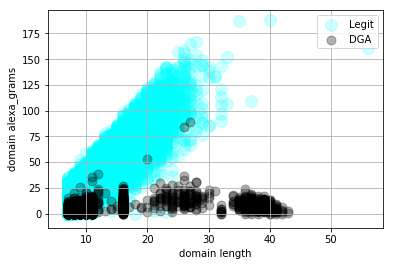

In [131]:
# Lets plot some stuff!
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
plot2Dfeatures(all_domains, 'length', 'alexa_grams', cond)

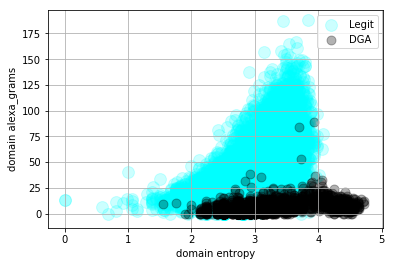

In [132]:
plot2Dfeatures(all_domains, 'entropy', 'alexa_grams', cond)

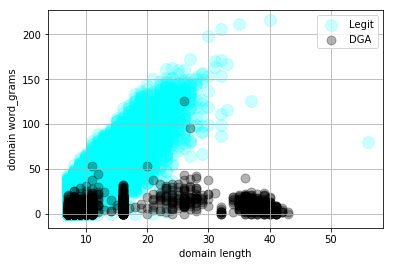

In [133]:
plot2Dfeatures(all_domains, 'length', 'word_grams', cond)

Notice that with ngrams, the overlap is significantly lower than back when we only have length and entropy as features. We are on to something...

Lets look at which Legit domains are scoring low on the word gram count.

In [134]:
all_domains[(all_domains['word_grams']==0)].head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
581,scz-bbs,legit,7,2.235926,2.854306,0.0,2.854306
636,757207049,weird,9,2.419382,0.000000,0.0,0.000000
890,bbqguys,legit,7,2.521641,4.305996,0.0,4.305996
2865,aek1924,weird,7,2.807355,0.000000,0.0,0.000000
2907,emxp001,weird,7,2.521641,1.724276,0.0,1.724276


This is weird, because some of these domains are suspicious, yet Alexa labeled them as legit.

Lets look at which Legit domains are scoring low on both alexa and word gram count.

In [135]:
weird_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['alexa_grams']<2)
weird = all_domains[weird_cond]
print(weird.shape[0])
weird.head()

0


,domain,class,length,entropy,alexa_grams,word_grams,diff


### Epiphany...
A human looking at some of these domains would definitely label these as DGA, yet Alexa labeled them as legit. PerhapsAlexa really may not be the best 'exemplar' labeler?

### Discussion: 
If you're using these as exemplars of NOT DGA, then your probably making things very hard on your machine learning algorithm. Perhaps we should have two categories of Alexa domains, **'legit'** and a **'weird'**. based on some definition of weird. Looking at the entries above... we have approx 80 domains that we're going to mark as **'weird'**.

In [136]:
all_domains.loc[weird_cond, 'class'] = 'weird'
print(all_domains['class'].value_counts())
all_domains[all_domains['class'] == 'weird'].head()

legit    60383
dga       2397
weird       91
Name: class, dtype: int64


,domain,class,length,entropy,alexa_grams,word_grams,diff
636,757207049,weird,9,2.419382,0.000000,0.000000,0.000000
2057,xn--42cgk1gc8crdb1htg3d,weird,23,3.849224,1.301030,1.633468,-0.332438
2865,aek1924,weird,7,2.807355,0.000000,0.000000,0.000000
2907,emxp001,weird,7,2.521641,1.724276,0.000000,1.724276
4034,05tz2e9,weird,7,2.807355,0.000000,0.000000,0.000000


Now we try our machine learning algorithm again with the new features Alexa and Dictionary NGrams and the exclusion of the bad exemplars.

In [140]:
X = all_domains[['length', 'entropy', 'alexa_grams', 'word_grams']].values
y = np.array(all_domains['class'].tolist())

# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.57% (12033/12085)
legit/weird: 0.00% (0/12085)
legit/dga: 0.43% (52/12085)
weird/legit: 0.00% (0/21)
weird/weird: 19.05% (4/21)
weird/dga: 80.95% (17/21)
dga/legit: 17.48% (82/469)
dga/weird: 1.07% (5/469)
dga/dga: 81.45% (382/469)


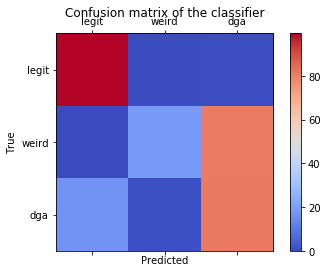

In [141]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

That seem to work 'ok', but you don't really want a classifier that outputs 3 classes, you'd like a classifier that flags domains as DGA or not.
This was a path that seemed like a good idea until it wasn't....

In [143]:
# Perhaps we will just exclude the weird class from our ML training
not_weird = all_domains[all_domains['class'] != 'weird']
X = not_weird[['length', 'entropy', 'alexa_grams', 'word_grams']].values

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(not_weird['class'].tolist())

# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.63% (12057/12102)
legit/dga: 0.37% (45/12102)
dga/legit: 14.10% (64/454)
dga/dga: 85.90% (390/454)


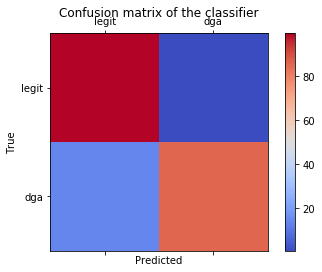

In [144]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels) 

### Why Remove Bad Exemplars?
It's definitely better.. but haven't we just cheated by removing
the weird domains?  Well perhaps, but on some level we're removing
outliers that are bad exemplars. So to validate that the model is still
doing the right thing lets try our new model prediction on our hold out sets.

In [146]:
# First train on the whole thing before looking at prediction performance
model.fit(X, y)

# Pull together our hold out set
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)

# Add a length field for the domain
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

# Add a entropy field for the domain
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]

# Compute NGram matches for all the domains and add to our dataframe
hold_out_domains['alexa_grams']= alexa_counts * alexa_cv.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * word_cv.transform(hold_out_domains['domain']).T

hold_out_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
0,gamersgate,legit,10,2.721928,32.047565,30.480728
1,procreditbank,legit,13,3.546594,44.192888,53.168916
2,wellsfargoadvisors,legit,18,3.461320,45.949812,60.955059
3,tfmetalsreport,legit,14,3.182006,40.590348,49.183052
4,cruisemates,legit,11,3.095795,36.906571,49.753723


Confusion Matrix Stats
legit/legit: 99.37% (6795/6838)
legit/dga: 0.63% (43/6838)
dga/legit: 15.36% (41/267)
dga/dga: 84.64% (226/267)


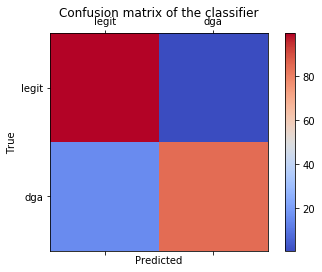

In [148]:
# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
hold_X = hold_out_domains[['length', 'entropy', 'alexa_grams', 'word_grams']].values

# Labels (scikit learn uses 'y' for classification labels)
hold_y = np.array(hold_out_domains['class'].tolist())

# Now run through the predictive model
hold_y_pred = model.predict(hold_X)

# Add the prediction array to the dataframe
hold_out_domains['pred'] = hold_y_pred

# Now plot the results
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 

# Part 6: Post Analysis
 Okay so on our 10% hold out set of 10k domains about ~100 domains were mis-classified
 at this point we're made some good progress so we're going to claim success :)
       - Out of 10k domains 100 were mismarked
       - false positives (Alexa marked as DGA) = ~0.6%
       - about 80% of the DGA are getting marked

 Note: Alexa 1M results on the 10% hold out (100k domains) were in the same ballpark 
       - Out of 100k domains 432 were mismarked
       - false positives (Alexa marked as DGA) = 0.4%
       - about 70% of the DGA are getting marked
 Now were going to just do some post analysis on how the ML algorithm performed.

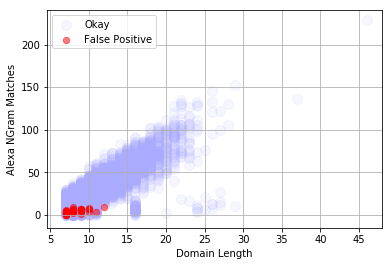

In [149]:
# Lets look at a couple of plots to see which domains were misclassified.
# Looking at Length vs. Alexa NGrams
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dga') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
plt.scatter(okay['length'], okay['alexa_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.1)
plt.scatter(fp['length'], fp['alexa_grams'], s=40, c='r', label='False Positive', alpha=.5)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Alexa NGram Matches')
plt.show()

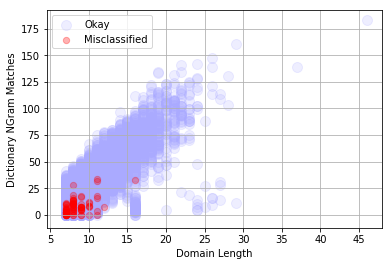

In [150]:
# Looking at Length vs. Dictionary NGrams
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
plt.scatter(okay['length'], okay['word_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.2)
plt.scatter(misclassified['length'], misclassified['word_grams'], s=40, c='r', label='Misclassified', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Dictionary NGram Matches')
plt.show()

In [151]:
misclassified.head()

,domain,class,length,entropy,alexa_grams,word_grams,pred
337,mivzakim,legit,8,2.500000,5.055913,6.567609,dga
512,za10groszy,legit,10,3.121928,7.860502,8.470172,dga
589,weige998,legit,8,2.500000,6.499757,10.194583,dga
923,rkg1866,legit,7,2.521641,0.000000,0.000000,dga
1338,thaqafnafsak,legit,12,2.751629,8.774784,7.132364,dga


In [152]:
misclassified[misclassified['class'] == 'dga'].head()

,domain,class,length,entropy,alexa_grams,word_grams,pred
9139,uolsugtlg,dga,9,2.503258,6.551345,4.696933,legit
9149,usbiezgac,dga,9,3.169925,7.687012,7.725389,legit
9150,ushcnewo,dga,8,3.000000,12.300790,10.144390,legit
9155,utamehz,dga,7,2.807355,10.774239,11.220143,legit
9157,utfowept,dga,8,2.750000,7.036206,12.106112,legit


In [154]:
# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'alexa_grams', 'word_grams'], model.feature_importances_)

for feature, importance in importances:
    print("{}: {}".format(feature, importance))

length: 0.13147269350726448
entropy: 0.15277226747236444
alexa_grams: 0.4461431890333486
word_grams: 0.26961184998702237


From the list below we see our feature importance scores. There's a lot of feature selection, sensitivity study, and other stuff that you could do if you wanted at this point.

## Part 7: Deploying the Model

Typically Machine Learning comes in two phases
    1. Training of the Model
    2. Evaluation of new observations against the Model
This notebook is about exploration of the data and training the model. After you have a model that you are satisfied with, just 'pickle' it at the end of the your training script and then in a separate evaluation script 'unpickle' it and evaluate/score new observations coming in (through a file, or ZeroMQ, or whatever...)

In this case we'd have to pickle the **RandomForestClassifier** and the two vectorizing transforms (alexa_grams and word_grams).
See 'test_it' below for how to use them in evaluation mode.

In [156]:
# Package everything into your classifier to aid in feature extraction in production
model.alexa_counts = alexa_counts
model.alexa_cv = alexa_cv
model.dict_counts = dict_counts
model.word_cv = word_cv

In [158]:
from sklearn.externals import joblib
joblib.dump(model, 'models/randomforest.pkl') 

['models/randomforest.pkl']

Some time later in production site ...

In [159]:
from sklearn.externals import joblib
import numpy as np

clf = joblib.load('models/randomforest.pkl') 

In [160]:
# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(domain):
    _alexa_match = clf.alexa_counts * clf.alexa_cv.transform([domain]).T
    _dict_match = clf.dict_counts * clf.word_cv.transform([domain]).T
    # Remember to run your entropy function again. Usually we import it as a user defined package in production
    list_data = [len(domain), entropy(domain), _alexa_match, _dict_match]
    _X = np.reshape(list_data, (-1,4))
    print('%s : %s' % (domain, clf.predict(_X)[0]))

In [161]:
# Examples (feel free to change these and see the results!)
# Try adding your own domains.
test_it('google')

google : legit


### Takeaways:
In this notebook, we gained a feel of supervised learning using DGA detection as a problem scenario. The main takeaways from this assignment are:
1. Intuition of supervised learning (Remember the toddler?) and why it needs labeled dataset.
2. Techniques of feature engineering.
3. Tecniques of model evaluation and why we don't measure accuracy only.

### Acknowledgements:
This assignment is adapted from the original notebook published by ClickSecurity. Link to their page will be provided at a later date.